In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [53]:
data = pd.read_csv('urine_biomarkers.csv')

In [54]:
data.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sample_id                590 non-null    object 
 1   patient_cohort           590 non-null    object 
 2   sample_origin            590 non-null    object 
 3   age                      590 non-null    int64  
 4   sex                      590 non-null    object 
 5   diagnosis                590 non-null    int64  
 6   stage                    199 non-null    object 
 7   benign_sample_diagnosis  208 non-null    object 
 8   plasma_CA19_9            350 non-null    float64
 9   creatinine               590 non-null    float64
 10  LYVE1                    590 non-null    float64
 11  REG1B                    590 non-null    float64
 12  TFF1                     590 non-null    float64
 13  REG1A                    306 non-null    float64
dtypes: float64(6), int64(2), o

2    208
3    199
1    183
Name: diagnosis, dtype: int64

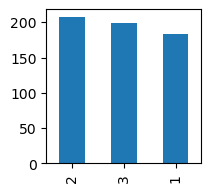

In [56]:
data.diagnosis.value_counts().plot.bar(figsize=(2, 2))
data['diagnosis'].value_counts()

In [57]:
data.sex = data.sex.apply(lambda x: 1 if x=='M' else 0)

"stage" and "benign sample diagnosis" should be excluded from the analysis sicne they are part of the diagnosis, whereas "sample id", "sample origin" and 'patient cohort" are not informative for the diagnosis and will also be omitted

In [58]:
data=data.drop(['sample_id', 'sample_origin', 'patient_cohort', 'stage', 'benign_sample_diagnosis'], axis=1)

In [59]:
data.plasma_CA19_9 = data.plasma_CA19_9.transform(lambda x: x.fillna(x.median())).round(0)

In [60]:
data.REG1A = data.REG1A.transform(lambda x: x.fillna(x.median())).round(0)

Multiple classification:

In [91]:
cols_corr = data.corr().nlargest(10, 'diagnosis')['diagnosis'].index.tolist()
cols_corr

['diagnosis',
 'LYVE1',
 'REG1B',
 'TFF1',
 'age',
 'plasma_CA19_9',
 'REG1A',
 'sex',
 'creatinine']

The Biomarker panel described in the PLOS paper, does not include creatinine, REG1A and plasma_CA19_9, so they will not be included in the analysis. 

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['diagnosis', 'REG1A', 'plasma_CA19_9', 'creatinine', 'sex', 'age'], axis=1), data['diagnosis'], test_size=0.33, random_state=1,
stratify=data['diagnosis'])

First a classical ML model

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

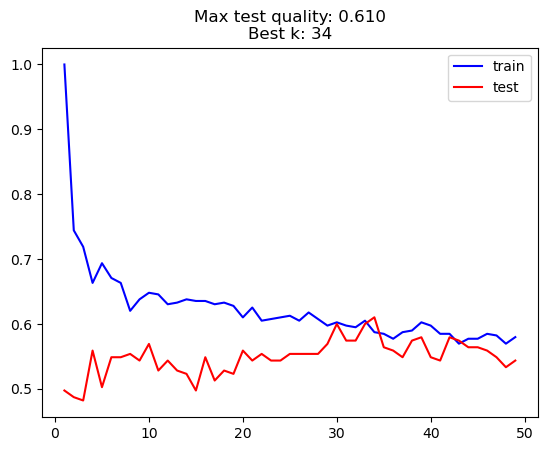

In [64]:
from sklearn.model_selection import cross_val_score
neighbors = range(1, 50)
accuracy_score_train = []
accuracy_score_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    accuracy_score_train.append(accuracy_score(knn.predict(X_train_scaled), y_train))
    accuracy_score_test.append(accuracy_score(knn.predict(X_test_scaled), y_test))
    
plt.plot(neighbors, accuracy_score_train, color='blue', label='train')
plt.plot(neighbors, accuracy_score_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(accuracy_score_test), np.argmax(accuracy_score_test)+1))
plt.legend();

In [65]:
knn = KNeighborsClassifier(n_neighbors=34)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=34)

In [66]:
accuracy_score(knn.predict(X_test_scaled), y_test)

0.6102564102564103

What if all available clinical parameters are included in the analysis, regradless of what the established Biomarker panel consists of

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['diagnosis', 'sex', 'age'], axis=1), data['diagnosis'], test_size=0.33, random_state=1,
stratify=data['diagnosis'])

In [68]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

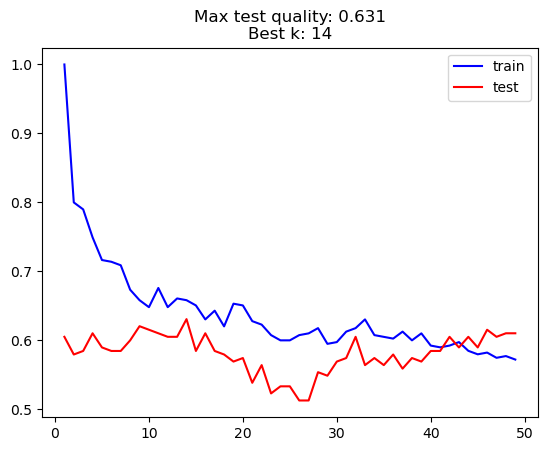

In [69]:
from sklearn.model_selection import cross_val_score
neighbors = range(1, 50)
accuracy_score_train = []
accuracy_score_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    accuracy_score_train.append(accuracy_score(knn.predict(X_train_scaled), y_train))
    accuracy_score_test.append(accuracy_score(knn.predict(X_test_scaled), y_test))
    
plt.plot(neighbors, accuracy_score_train, color='blue', label='train')
plt.plot(neighbors, accuracy_score_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(accuracy_score_test), np.argmax(accuracy_score_test)+1))
plt.legend();

In [70]:
knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=14)

In [71]:
accuracy_score(knn.predict(X_test_scaled), y_test)

0.6307692307692307

A more sophisticated model

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['diagnosis', 'sex'], axis=1), data['diagnosis'], test_size=0.33, random_state=1,
stratify=data['diagnosis'])

In [249]:
parameters = {'n_estimators': [5, 10, 50, 100, 500]}
tuning = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'accuracy')
tuning.fit(X_train, y_train)
pred = tuning.predict(X_test)
tuning.best_params_

{'n_estimators': 50}

In [250]:
parameters = {'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.90, 0.92, 0.95, 1.0]}
tuning = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'accuracy')
tuning.fit(X_train, y_train)
pred = tuning.predict(X_test)
tuning.best_params_

{'max_features': 1.0}

In [251]:
parameters = {'max_samples': [x / 10 for x in range(1, 11)]}
tuning = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'accuracy')
tuning.fit(X_train, y_train)
pred = tuning.predict(X_test)
tuning.best_params_ 

{'max_samples': 0.7}

In [252]:
parameters = {'criterion': ['gini', 'entropy']}
tuning = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'accuracy')
tuning.fit(X_train, y_train)
pred = tuning.predict(X_test)
tuning.best_params_

{'criterion': 'gini'}

In [253]:
parameters = {'max_depth': [1, 3, 5, 10, 15, 20]}
tuning = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'accuracy')
tuning.fit(X_train, y_train)
pred = tuning.predict(X_test)
tuning.best_params_

{'max_depth': 15}

In [75]:
RF = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth = 15, max_features=0.2, max_samples=0.8, criterion='entropy')
RF.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, max_features=0.2,
                       max_samples=0.8, n_estimators=50, n_jobs=-1)

In [76]:
accuracy_score(RF.predict(X_test), y_test)

0.676923076923077

In [81]:
RF = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth = 15, max_features=1.0, max_samples=0.7, criterion='gini')
RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=1.0, max_samples=0.7,
                       n_estimators=50, n_jobs=-1)

In [82]:
accuracy_score(RF.predict(X_test), y_test)

0.717948717948718

In [83]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

In [84]:
accuracy_score(RF.predict(X_test), y_test)

0.6974358974358974

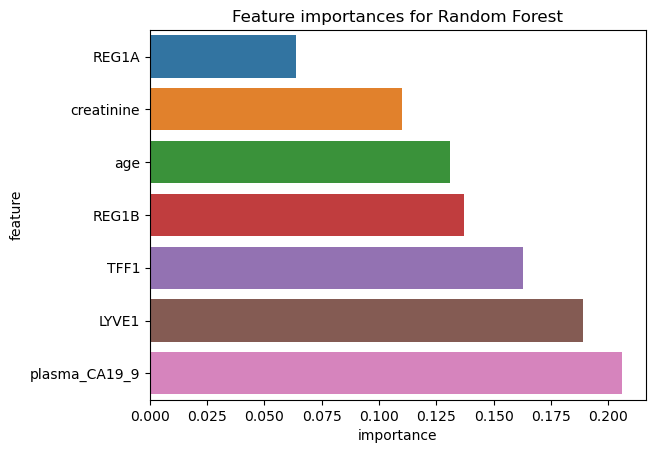

In [85]:
feature_importances = zip(X_train.columns, RF.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1])
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

plt.title('Feature importances for Random Forest')
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

In [86]:
!pip install lightgbm

In [87]:
from lightgbm import LGBMClassifier
lightgbm = LGBMClassifier(n_estimators=400, n_jobs=-1, max_depth = 15, num_leaves=3)
lightgbm.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 7
[LightGBM] [Info] Start training from score -1.166701
[LightGBM] [Info] Start training from score -1.044412
[LightGBM] [Info] Start training from score -1.088537


LGBMClassifier(max_depth=15, n_estimators=400, n_jobs=-1, num_leaves=3)

In [88]:
accuracy_score(lightgbm.predict(X_test), y_test)

0.7230769230769231

Binary classification

In [89]:
data.diagnosis = data.diagnosis.apply(lambda x: 1 if x==3 else 0)

0    391
1    199
Name: diagnosis, dtype: int64

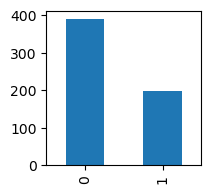

In [90]:
data.diagnosis.value_counts().plot.bar(figsize=(2, 2))
data['diagnosis'].value_counts()

In [92]:
cols_corr = data.corr().nlargest(10, 'diagnosis')['diagnosis'].index.tolist()
cols_corr

['diagnosis',
 'LYVE1',
 'REG1B',
 'TFF1',
 'age',
 'plasma_CA19_9',
 'REG1A',
 'sex',
 'creatinine']

In [138]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['diagnosis'], axis=1), data['diagnosis'], test_size=0.33, random_state=1,
stratify=data['diagnosis'])

In [139]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#'plasma_CA19_9'

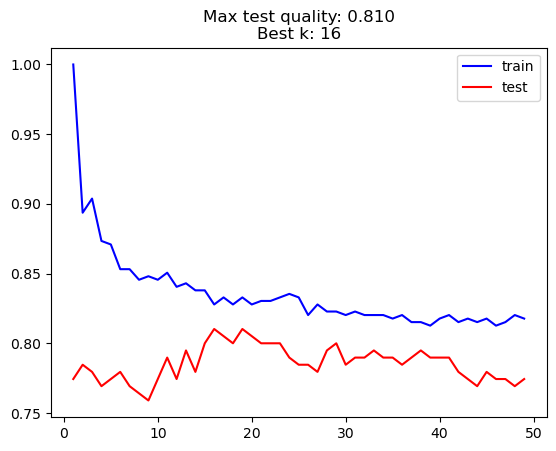

In [140]:
from sklearn.model_selection import cross_val_score
neighbors = range(1, 50)
accuracy_score_train = []
accuracy_score_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    accuracy_score_train.append(accuracy_score(knn.predict(X_train_scaled), y_train))
    accuracy_score_test.append(accuracy_score(knn.predict(X_test_scaled), y_test))
    
plt.plot(neighbors, accuracy_score_train, color='blue', label='train')
plt.plot(neighbors, accuracy_score_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(accuracy_score_test), np.argmax(accuracy_score_test)+1))
plt.legend();

In [141]:
knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=16)

In [142]:
accuracy_score(knn.predict(X_test_scaled), y_test)

0.8102564102564103

In [145]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['diagnosis', 'sex'], axis=1), data['diagnosis'], test_size=0.33, random_state=1,
stratify=data['diagnosis'])

In [166]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

In [167]:
accuracy_score(RF.predict(X_test), y_test)

0.8717948717948718

In [148]:
parameters = {'n_estimators': [5, 10, 50, 100, 500]}
tuning = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'accuracy')
tuning.fit(X_train, y_train)
pred = tuning.predict(X_test)
tuning.best_params_

{'n_estimators': 500}

In [149]:
parameters = {'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.90, 0.92, 0.95, 1.0]}
tuning = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'accuracy')
tuning.fit(X_train, y_train)
pred = tuning.predict(X_test)
tuning.best_params_

{'max_features': 0.92}

In [150]:
parameters = {'max_samples': [x / 10 for x in range(1, 11)]}
tuning = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'accuracy')
tuning.fit(X_train, y_train)
pred = tuning.predict(X_test)
tuning.best_params_ 

{'max_samples': 0.6}

In [151]:
parameters = {'criterion': ['gini', 'entropy']}
tuning = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'accuracy')
tuning.fit(X_train, y_train)
pred = tuning.predict(X_test)
tuning.best_params_

{'criterion': 'gini'}

In [152]:
parameters = {'max_depth': [1, 3, 5, 10, 15, 20]}
tuning = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'accuracy')
tuning.fit(X_train, y_train)
pred = tuning.predict(X_test)
tuning.best_params_

{'max_depth': 15}

In [160]:
RF = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth = 15, max_features=0.92, max_samples=0.6, criterion='gini')
RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=0.92, max_samples=0.6,
                       n_estimators=500, n_jobs=-1)

In [161]:
accuracy_score(RF.predict(X_test), y_test)

0.8769230769230769

In [186]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 133, number of negative: 262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.336709 -> initscore=-0.677995
[LightGBM] [Info] Start training from score -0.677995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMClassifier()

In [187]:
accuracy_score(lightgbm.predict(X_test), y_test)

0.841025641025641

In [188]:
parameters = {'n_estimators': [5,10,50, 100, 500], 'max_features' : [1, 2, 3], 'max_depth':[1, 3, 5, 10, 15], 'num_leaves':[1, 3, 5, 10]}

model = LGBMClassifier()
clf = GridSearchCV(model, parameters, scoring = 'accuracy')

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f'Actual test score: {accuracy_score(pred, y_test):.4f}')
print('Best parameters: ', clf.best_params_)

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 106, number of negative: 210
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335443 -> initscore=-0.683668
[LightGBM] [Info] Start training from score -0.683668
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown param

In [199]:
lightgbm = LGBMClassifier(n_estimators=100, max_depth = 15, num_leaves=3, n_jobs=-1)
lightgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 133, number of negative: 262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.336709 -> initscore=-0.677995
[LightGBM] [Info] Start training from score -0.677995


LGBMClassifier(max_depth=15, n_jobs=-1, num_leaves=3)

In [200]:
accuracy_score(lightgbm.predict(X_test), y_test)

0.8769230769230769